In this notebook, I will generate the SubPositive dataset and plot it using pca.

First, defining the path:

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = '/mnt/scratch/rebac002/data/AllPositive2'
#path_data = '/mnt/scratch/louwe015/Mass_differences/data'
sys.path.insert(0, ROOT)

Picking the correct file (AllPositive2 dataset):

In [2]:
import pickle
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as filename:
    spectrums = pickle.load(filename)

Text(0, 0.5, 'number of spectra in respective bin')

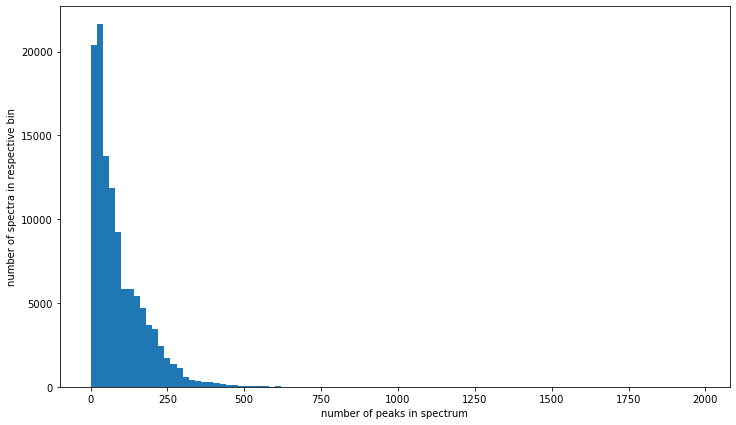

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Post-process data**

We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

**Post-processing for Spec2Vec**
Spec2Vec similarity scores rely on creating a document vector for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.

-normalize peaks (maximum intensity to 1)
-remove peaks outside [0, 1000] m/z window
-remove spectra with < 10 peaks
-reduce number of peaks to maximum of 0.5 * parent mass
-remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import add_losses


def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

115388 remaining spectra.


In [5]:
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle'), "wb"))

In [6]:
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

In [7]:
np.max(number_of_peaks)

982

Text(0, 0.5, 'number of spectra in respective bin')

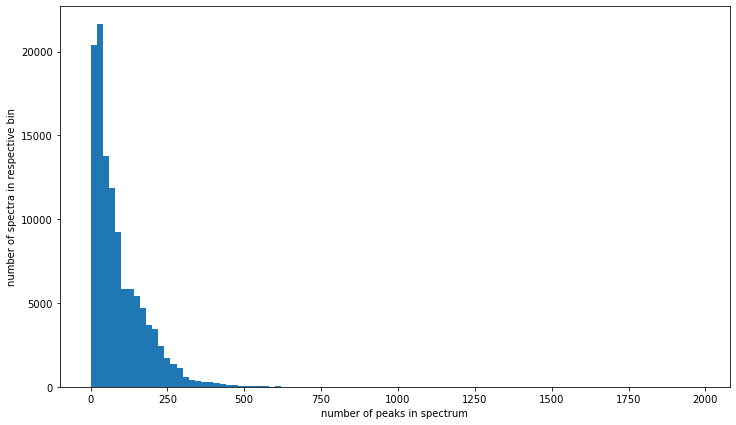

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Inspect annotations**

In [9]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:20]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
SRIGHEHXEGELQJ    338
IQGPMZRCLCCXAG    308
IIZPXYDJLKNOIY    235
FYVNIFOYDIIODX    235
RWKUXQNLWDTSLO    235
BHWGKAVGUMMQIW    230
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    211
KILNVBDSWZSGLL    209
RFVFQQWKPSOBED    203
IRYMXEVDAKMFIF    198
IESVDEZGAHUQJU    197
SNKAWJBJQDLSFF    196
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
XGGMHQYOVYWRLV    180
LSOWKZULVQWMLY    180
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

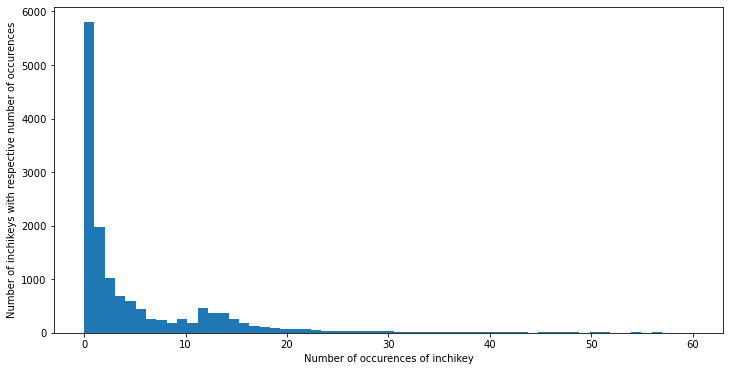

In [10]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

**Randomly select 1000 inchikeys that exist >=30 times in the dataset**

In [11]:
min_copies_in_data = 30 #min nr of spectra per inchikey

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,SRIGHEHXEGELQJ,338
3,IQGPMZRCLCCXAG,308
6,RWKUXQNLWDTSLO,235
4,IIZPXYDJLKNOIY,235
5,FYVNIFOYDIIODX,235
7,BHWGKAVGUMMQIW,230
8,QIBZFHLFHCIUOT,225
9,ZAYXPDDGEIJGGW,212


In [12]:
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])
#check how many spectra there are for inchikeys that exist 30 or more times

Number of spectra with inchikeys that exist >= 30 times: 404


Here, select the inchikeys:

In [43]:
num_spectra = 20 #how many do you want to randomly select?
np.random.seed(35) # to make it reproducible

selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys

array(['TTWJBBZEZQICBI', 'QJWDAOSZZYVBJZ', 'HPNSFSBZBAHARI',
       'MCWXGJITAZMZEV', 'CLEXYFLHGFJONT', 'QUQPHWDTPGMPEX',
       'LNEPOXFFQSENCJ', 'WQZGKKKJIJFFOK', 'MUMGGOZAMZWBJJ',
       'DNTGGZPQPQTDQF', 'OXASEZHJIONDOQ', 'NGFMICBWJRZIBI',
       'REFJWTPEDVJJIY', 'SVOUGFFDROZBJI', 'ODKSFYDXXFIFQN',
       'SOSLMHZOJATCCP', 'UATOAILWGVYRQS', 'XSDQTOBWRPYKKA',
       'JLPULHDHAOZNQI', 'RPTUKVYGSPDHGQ'], dtype=object)

In [36]:
print(len(selected_inchikeys)) #check how many inchikeys are selected

20


Now that we selcted the inchikeys, we need to trace back which spectra they represent and select those spectra:

In [41]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!
np.random.seed(35) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

In [40]:
print(len(selected_spectra)) #check how many spectra are selected

1313


Import model pre-trained on AllPositive2 dataset (will need it for vector calculation):

In [44]:
filename_path = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_embedding_iter_15.model"
filename_model = os.path.join(path_data, filename_path)

pretrained_model = gensim.models.Word2Vec.load(filename_model)

In [45]:
next(iter(pretrained_model.wv.vocab))

'peak@289.29'

In [46]:
from spec2vec import SpectrumDocument

spectrum_documents = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums) if i in selected_spectra]

from spec2vec import Spec2Vec
spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

Define function for calculating a vector:

In [47]:
from typing import Union
import numba
import numpy
from gensim.models.basemodel import BaseTopicModel
from spec2vec.Document import Document

def calc_vector(model: BaseTopicModel, document: Document,
                intensity_weighting_power: Union[float, int] = 0,
                allowed_missing_percentage: Union[float, int] = 0):
    assert max(document.weights) <= 1.0, "Weights are not normalized to unity as expected."
    assert 0 <= allowed_missing_percentage <= 100.0, "allowed_missing_percentage must be within [0,100]"
    def _check_model_coverage():
        if len(idx_not_in_model) > 0:
            weights_missing = numpy.array([document.weights[i] for i in idx_not_in_model])
            weights_missing_raised = numpy.power(weights_missing, intensity_weighting_power)
            missing_percentage = 100 * weights_missing_raised.sum() / (weights_raised.sum()
                                                                       + weights_missing_raised.sum())
            print("Found {} word(s) missing in the model.".format(len(idx_not_in_model)),
                  "Weighted missing percentage not covered by the given model is {:.2f}%.".format(missing_percentage))

            message = ("Missing percentage is larger than set maximum.",
                       "Consider retraining the used model or increasing the allowed percentage.")
            assert missing_percentage <= allowed_missing_percentage, message

    idx_not_in_model = [i for i, x in enumerate(document.words) if x not in model.wv.vocab]
    words_in_model = [x for i, x in enumerate(document.words) if i not in idx_not_in_model]
    weights_in_model = numpy.asarray([x for i, x in enumerate(document.weights)
                                      if i not in idx_not_in_model]).reshape(len(words_in_model), 1)

    word_vectors = model.wv[words_in_model]
    weights_raised = numpy.power(weights_in_model, intensity_weighting_power)

    _check_model_coverage()

    weights_raised_tiled = numpy.tile(weights_raised, (1, model.wv.vector_size))
    vector = numpy.sum(word_vectors * weights_raised_tiled, 0)
    return vector

The function above calculates only a single vector from a single document. To make it calculate all our vectors from spectrum_documents, a for loop is used. I also used a numpy array instead of a regular list to improve performance. Each "single_vector" is a list of 300 (dimensions), and there are 1313 "single_vector"s in total.

In [60]:
for i in spectrum_documents:
    single_vector = calc_vector(pretrained_model, i)

spec_vectors = np.stack(list_of_vectors)
len(spec_vectors)

1313

In [59]:
print(spec_vectors)

[[   9.6675273     0.9085947   -27.70980746 ...  -17.25872673
    19.57642086    9.93873076]
 [  44.23753337  -40.96642782   79.90447517 ...   -9.75198705
    56.63476892  -30.02396515]
 [  78.4794752   -15.0218104    25.66276561 ...    3.01092309
   -18.38444841  -46.58366317]
 ...
 [ -73.37632075  108.29153866  -26.34352268 ...  -12.51649548
    28.25609475   -6.91202805]
 [ -26.39815399  -86.90799374   84.81196176 ...   44.81042392
    52.79297993 -144.02998215]
 [ -17.52484421 -128.19885506  -85.28768772 ...   65.2106959
  -184.07511378   86.18608033]]


**PCA VISUALIZATION**

In [75]:
from pca import pca
import numpy as np
from sklearn.datasets import load_iris

#load dataset
spec_dataset = spec_vectors

#reduce the data up to the number of components that explains 95% of the variance
pca_model = pca(n_components=0.95)

#reduce data towards n PCs
#pca_model = pca(n_components=3)

results = pca_model.fit_transform(spec_dataset)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [300] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [177] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [76]:
print(results)

{'loadings':               1         2         3         4         5         6         7  \
PC1   -0.009040  0.045388  0.025720 -0.011585 -0.016439 -0.022939  0.010334   
PC2   -0.023809 -0.019731 -0.034714 -0.039722 -0.069122  0.119588 -0.070890   
PC3   -0.066330 -0.073558  0.025157 -0.060111 -0.011940 -0.033855 -0.002510   
PC4    0.053528 -0.045753  0.025678  0.058813  0.069056 -0.047370 -0.007766   
PC5    0.041983  0.009311 -0.021370  0.000362  0.030215 -0.089267 -0.029107   
...         ...       ...       ...       ...       ...       ...       ...   
PC296  0.031817 -0.079827 -0.021702 -0.026227  0.090706  0.032446  0.014409   
PC297  0.049387  0.057390  0.010083 -0.021836 -0.066032 -0.050302 -0.002965   
PC298 -0.061347 -0.033571 -0.046095 -0.026896 -0.095105 -0.038295 -0.020559   
PC299 -0.011370 -0.083448  0.061902  0.051312  0.002356  0.010275 -0.014802   
PC300  0.044305 -0.064112 -0.018807  0.028314  0.068978 -0.003974  0.053952   

              8         9        10  .

Scatter plot:

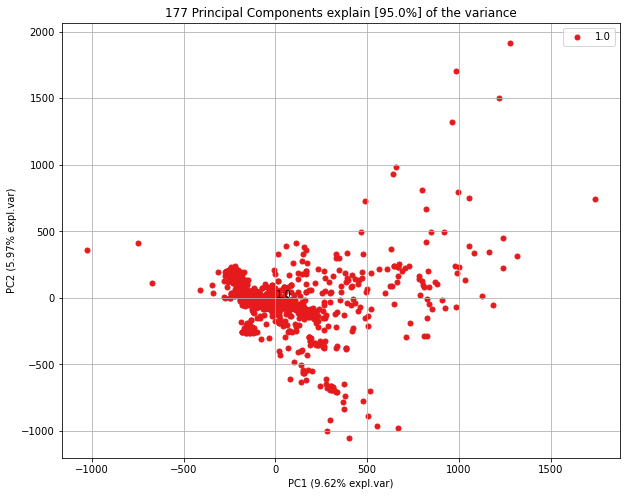

In [77]:
fig, ax = pca_model.scatter()

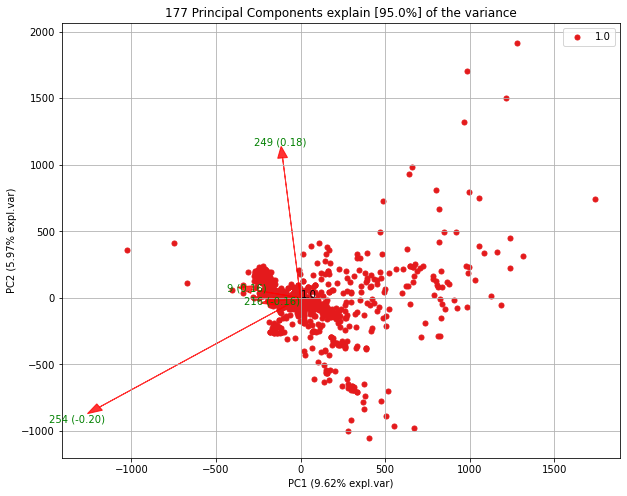

In [79]:
fig, ax = pca_model.biplot(n_feat=4)

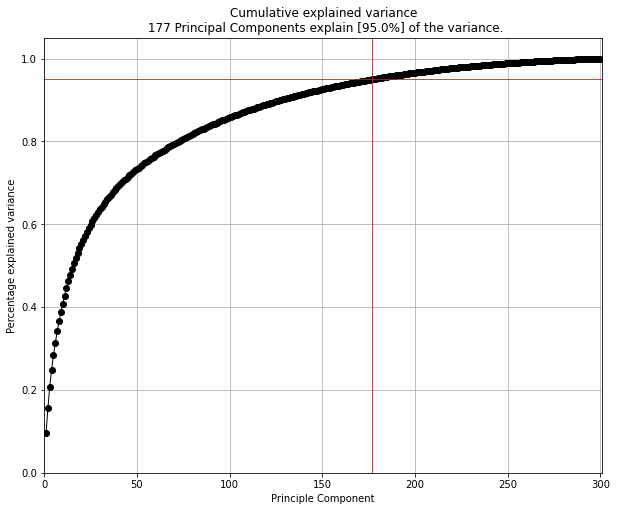

<Figure size 432x288 with 0 Axes>

In [80]:
fig, ax = pca_model.plot()

/mnt/scratch/rebac002/miniconda3/envs/BSc_Thesis/lib/python3.8/site-packages/pca/pca.py:821: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)


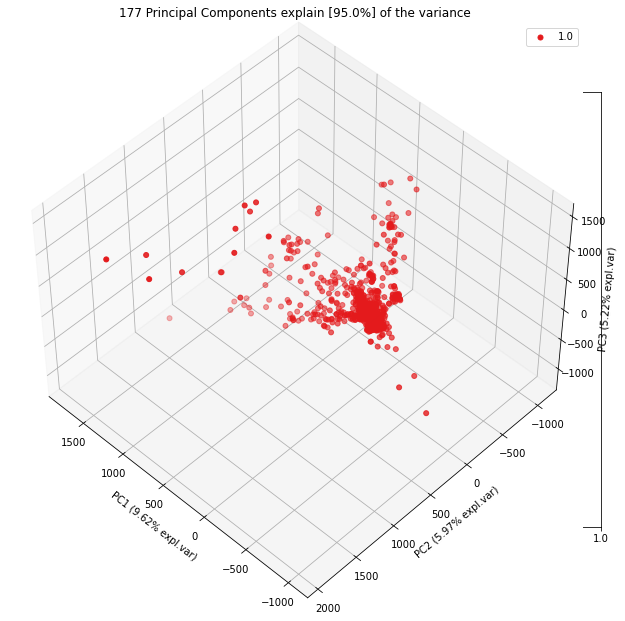

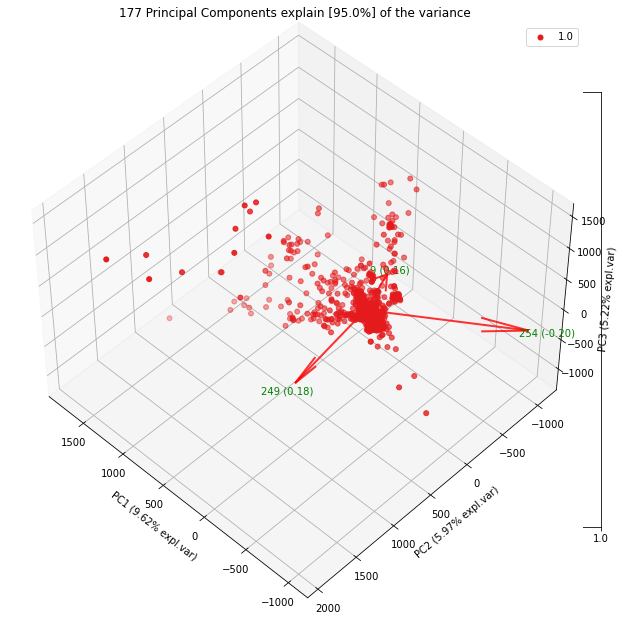

In [81]:
fig, ax = pca_model.scatter3d()
fig, ax = pca_model.biplot3d(n_feat=2)